# Introduction

Crimes are increasing at an alarming rate, and this poses a threat to society and public safety. According to the Met (Metropolitan Police), murders in the UK (2019 data) increased by 50% between 2017 and 2018. At the same time, firearm-related crimes increased by 25%, Knife-related crimes were committed at an alarming rate; it was found that London had the highest rate at 168 per 100,000 population (Marimbire et al., 2023). Studies have shown that there is a strong relationship between urbanization and crime. In the era of modern technology there is a steep increase in cybercrime (Furnelle and Dowling, 2019), stealing identity, F&CM (Fraud and Computer Misuse) and violating privacy.

The sheer number of crimes committed eventually increases the amount of data being stored. So, how do we tackle this issue? With the help of Big Data tools, different analyzing techniques and machine learning algorithms are used to overcome these issues.
In this project, we discuss the effect of the pandemic restriction on reported violent crimes. We’ll be using the UK Police Official Street level crime data (Police 2021) to assess if there is an increase in violent crimes after the lockdown was imposed.


In [ ]:
%%time

# Importing all the necessary packages
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import SparkFiles
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt, dates as mdates
import itertools
import warnings
import seaborn as sns
%matplotlib inline

CPU times: total: 31.2 ms
Wall time: 195 ms


## Significance of Spark

The data provided is a 2GB zipped filed (.gz) which contains crime data from 2010 to 2020. Spark is a unified engine for large scale data processing. Spark fragments the data and stores it in multiple clusters eventually makes the processing faster (Ferencz, Domokos and Levente Kovács, 2022). Spark also uses resilient distributed datasets (RDDs) to work parallel on the data. These properties help it perform better than pandas to read the file. Pandas data frame is stored in-memory which implies that the operations can be executed faster however, their size is limited by the memory of a single machine.(up to a few GBs, < 10GB).


In [ ]:
%%time

# Creating a spark session
spark = SparkSession.builder\
        .master('local[2]')\
        .appName("UK crime rate")\
        .getOrCreate()
spark
#.config("spark.driver.memory", "4g")
#.config("spark.sql.execution.arrow.enabled","true")

CPU times: total: 15.6 ms
Wall time: 7.88 s


%%time

#Creating a schema for the spark data frame

crime = StructType(
    [StructField("Crime ID", IntegerType(), True),
     StructField("Month", DateType(), True),
     StructField("Reported By", StringType(), True),
     StructField("Falls within", StringType(), True),
     StructField("Longitude", FloatType(), True),
     StructField("Latitude", FloatType(), True),
     StructField("Location", StringType(), True),
     StructField("LSOA code", StringType(), True),
     StructField("LSOA name", StringType(), True),
     StructField("Crime type", StringType(), True),
     StructField("Last outcome category", StringType(), True),
     StructField("Context", StringType(), True)
    ])

The file is being stored in the blob container which can be easily accessed using the blob link using the code below. The `sparkContext.addFile(url)` automatically decompresses the zipped file and stores it in a temporary location which then be accessed using `.read` using any format.

In [ ]:
url = # don't have access to the bucket anymore

spark.sparkContext.addFile(url)

df = spark.read.csv(SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, schema = crime)

In [ ]:
%%time
df.show(4)

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    NULL|2010-12|Avon and Somerset...|Avon and Somerset...|-0.805600|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 NULL|   NULL|
|    NULL|2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 NULL|   NULL|
|    NULL|2010-12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|

In [ ]:
df.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [ ]:
%%time
crimes = df.select("Crime type").groupBy("Crime type").count().sort("count")
crimes.show(truncate=False)

+----------------------------+--------+
|Crime type                  |count   |
+----------------------------+--------+
|Public disorder and weapons |242145  |
|Possession of weapons       |283189  |
|Robbery                     |696008  |
|Theft from the person       |714621  |
|Bicycle theft               |735689  |
|Violent crime               |1673219 |
|Drugs                       |1682486 |
|Public order                |2564695 |
|Other crime                 |2565111 |
|Shoplifting                 |3227557 |
|Vehicle crime               |4170769 |
|Burglary                    |4350252 |
|Other theft                 |5206259 |
|Criminal damage and arson   |5343182 |
|Violence and sexual offences|11411540|
|Anti-social behaviour       |20211528|
+----------------------------+--------+

CPU times: total: 0 ns
Wall time: 1min 58s


The table above shows that the data is being collected on 16 different types of crimes. Out of which the most registered crimes are of the type **Anti-Social behaviour** followed by **Violence and sexual offences**. We also see a similar type to the latter under the name **Violent Crime**.

The aim of the problem statement is to analyze and predict the number of crimes over a period, so we go ahead and select the date column and filter out the crime type column. Under violent crimes, we are considering *violence and sexual offences* as a part of **violent crimes**.

In [ ]:
%%time
df1 = df.select("Month", "Crime type")
violent = ['Violent crime', 'Violence and sexual offences'] #13,084,759

violent_df = df1.filter(df["Crime type"].isin(violent))
violent_df = violent_df.groupBy('Month').count() #grouping crime entries based on month

violent_df.show(10, truncate=False)

+-------+-----+
|Month  |count|
+-------+-----+
|2011-01|59823|
|2010-12|57580|
|2011-03|62326|
|2011-02|56691|
|2011-05|63633|
|2011-04|64299|
|2011-06|62475|
|2011-08|63284|
|2011-07|66572|
|2011-09|57150|
+-------+-----+
only showing top 10 rows

CPU times: total: 15.6 ms
Wall time: 1min 46s


In [ ]:
violent_df.printSchema()

root
 |-- Month: string (nullable = true)
 |-- count: long (nullable = false)



The information gained from different analyses must be translated graphically to gain valuable insights. Data visualization graphs like scatter plots, histograms, frequency distribution graphs, and heat maps are widely used in the field of crime analysis. Visualizing this data is done with ease using pandas.

Since the actual size of the  data frame contains more than 65 million rows converting all this data into pandas would cause a memory storage issue. Filtering out the required data based on the aim of  the experiment (***violent crimes***) can be done using spark functions like `select` and `filter`. Moving forward we can convert the extracted data into pandas using `toPandas()`.


It is mandatory to convert the data type feature ( in our case the  **Month**) and set it as the index. This is done so that we can visualize the time series data. Moving on we check if there are any null values present using the function `df.isnull().sum()`, if any present drop them using `df.dropna()`.  An aggregate group by function, `df.groupby(‘column name’).count()`is used to count the number of crimes committed in each month of the year.

In [ ]:
%%time
vpdf = violent_df.toPandas() #converting spark df to pandas

vpdf.set_index('Month', inplace=True)
vpdf.sort_index(inplace=True)
vpdf.index = pd.to_datetime(vpdf.index)

v_crime = vpdf.copy() #making a copy of the original data
v_crime.head(5)

CPU times: total: 15.6 ms
Wall time: 2min 6s


,count
Month,
2010-12-01,57580
2011-01-01,59823
2011-02-01,56691
2011-03-01,62326
2011-04-01,64299


# Analyszing the overall trend of violent crimes committed

The average number of violent crimes committed before locdown : 97415.0
The average number of violent crimes committed after locdown  : 155305.0 



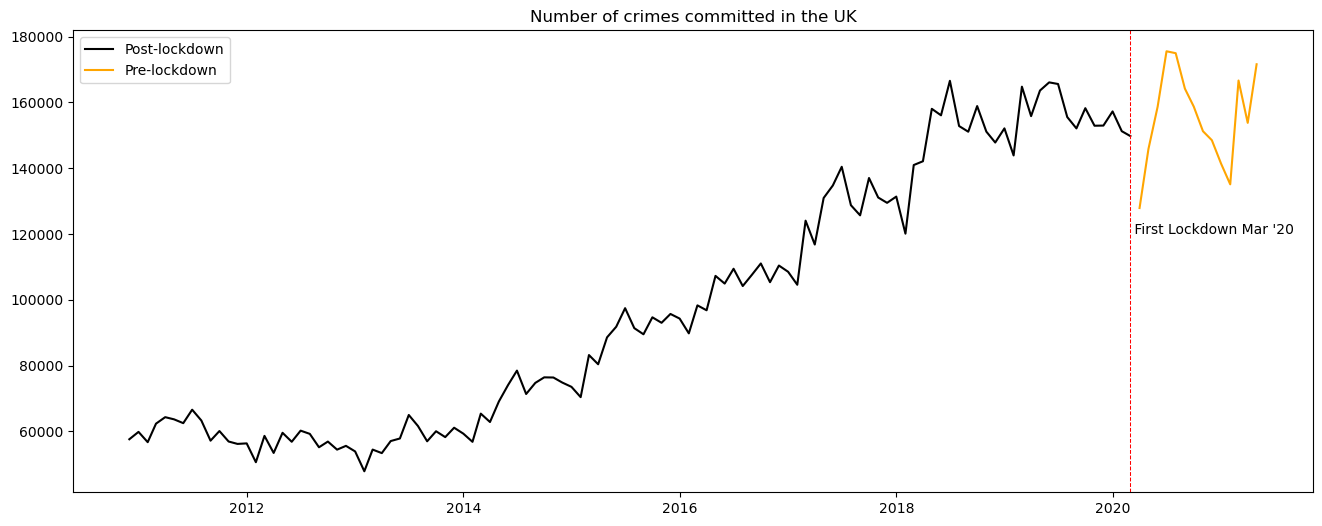

In [ ]:
lockdown = pd.to_datetime('2020-03-01')
pre_locdown = v_crime[v_crime.index < "2020-04-01"]
post_locdown = v_crime[v_crime.index >= "2020-04-01"]

prl = np.round(pre_locdown.mean()[0])
pol = np.round(post_locdown.mean()[0])
print("The average number of violent crimes committed before locdown :", prl)
print("The average number of violent crimes committed after locdown  :", pol, '\n')

plt.figure(figsize=(16,6))
plt.plot(pre_locdown, 'black', linewidth=1.5)
plt.plot(post_locdown, 'orange',linewidth=1.5)

# plotting a vertical line when the lockdown was imposed
plt.axvline(lockdown, linestyle='--', color = 'red', linewidth = 0.75)

plt.text(lockdown, 120000, " First Lockdown Mar '20")
plt.legend(['Post-lockdown', 'Pre-lockdown'])
plt.title('Number of crimes committed in the UK')
plt.show()

Visualizing the time series, we observe that the magnitude of crime committed has increased over the years. Additionally, we observe recurring minor fluctuations. Smoothening the time series is one of the methods used to detect and analyze hidden trends and patterns. Thereby, gaining valuable insights and determining which time series analysis to be used.

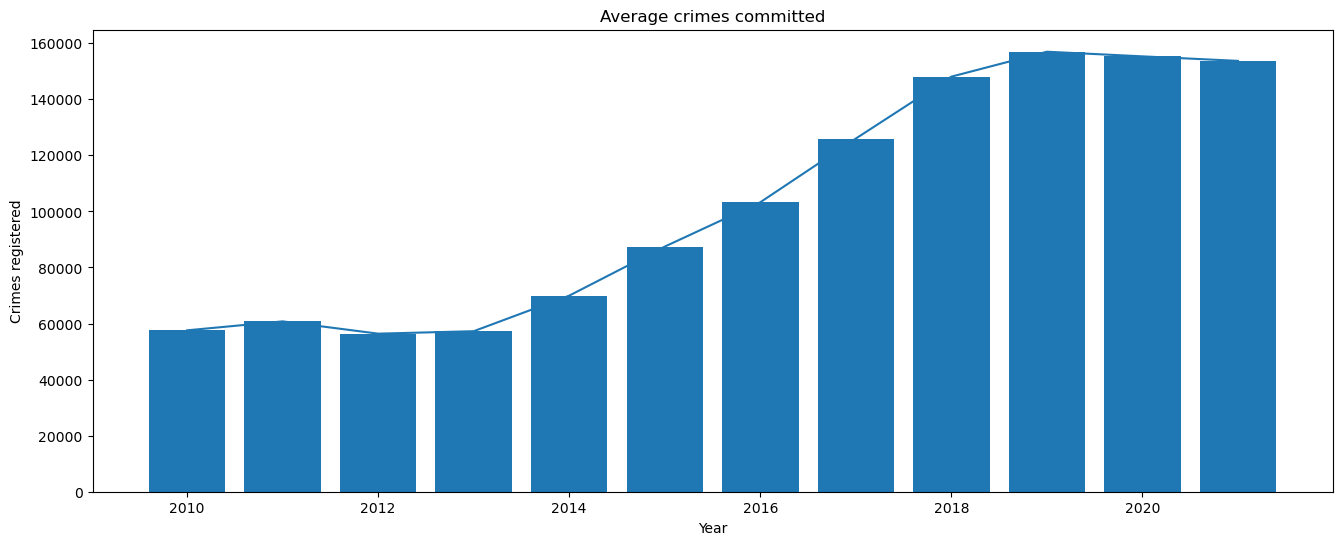

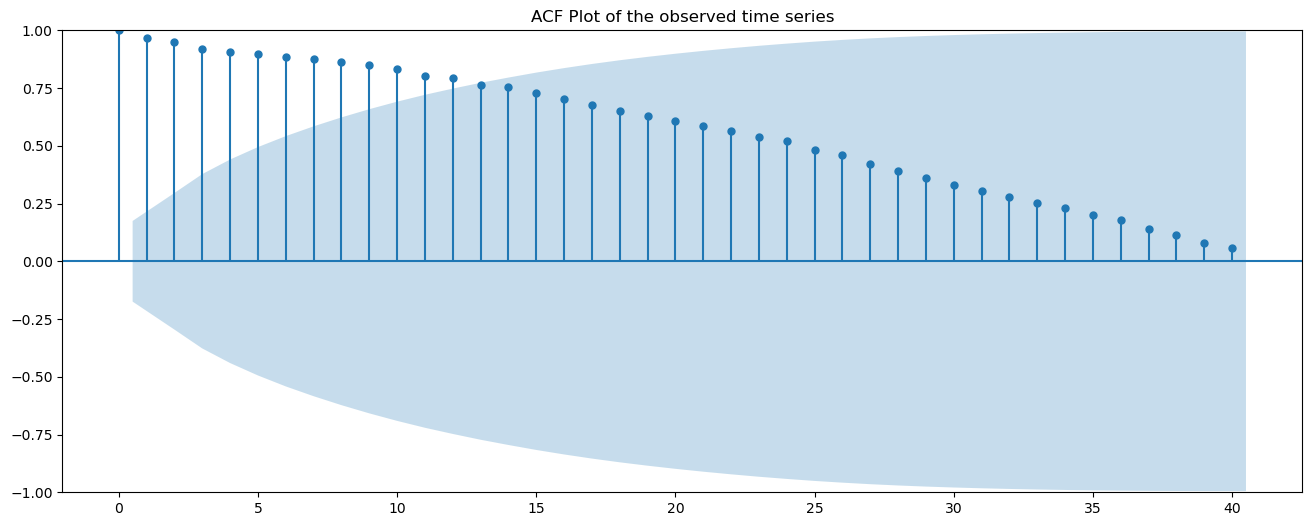

In [ ]:
yearly_avg = v_crime.groupby(v_crime.index.year).mean()

#Histogram
plt.figure(figsize=(16,6))
plt.plot(yearly_avg['count'])
plt.bar(yearly_avg.index, yearly_avg['count'])
plt.title("Average crimes committed")
plt.xlabel('Year')
plt.ylabel('Crimes registered')

plt.xlabel('Year')
plt.show()

# Autocorrelation plot
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(v_crime, lags = 40, title='Crime count', ax=ax)
plt.title("ACF Plot of the observed time series")
plt.show()


From the histogram plotted we can infer that the average number of crimes plotted have significantly increased after 2013. The slow decay in ACF plot implies that there is a positive correlation between past and future values. Ultimately meaning that there is an upward trend.

Additionally, trend can also be calculated by plotting the rolling mean where window size basically determines the number of points to calculate the moving average. The larger the window the smoother the data which eventually depicts the general direction of the times series i.e. uptrend, no trend or down trend. The only tradeoff is that over a large window the responsiveness is less.
Here, I am plotting the moving average over different window sizes and compare their characteristics.

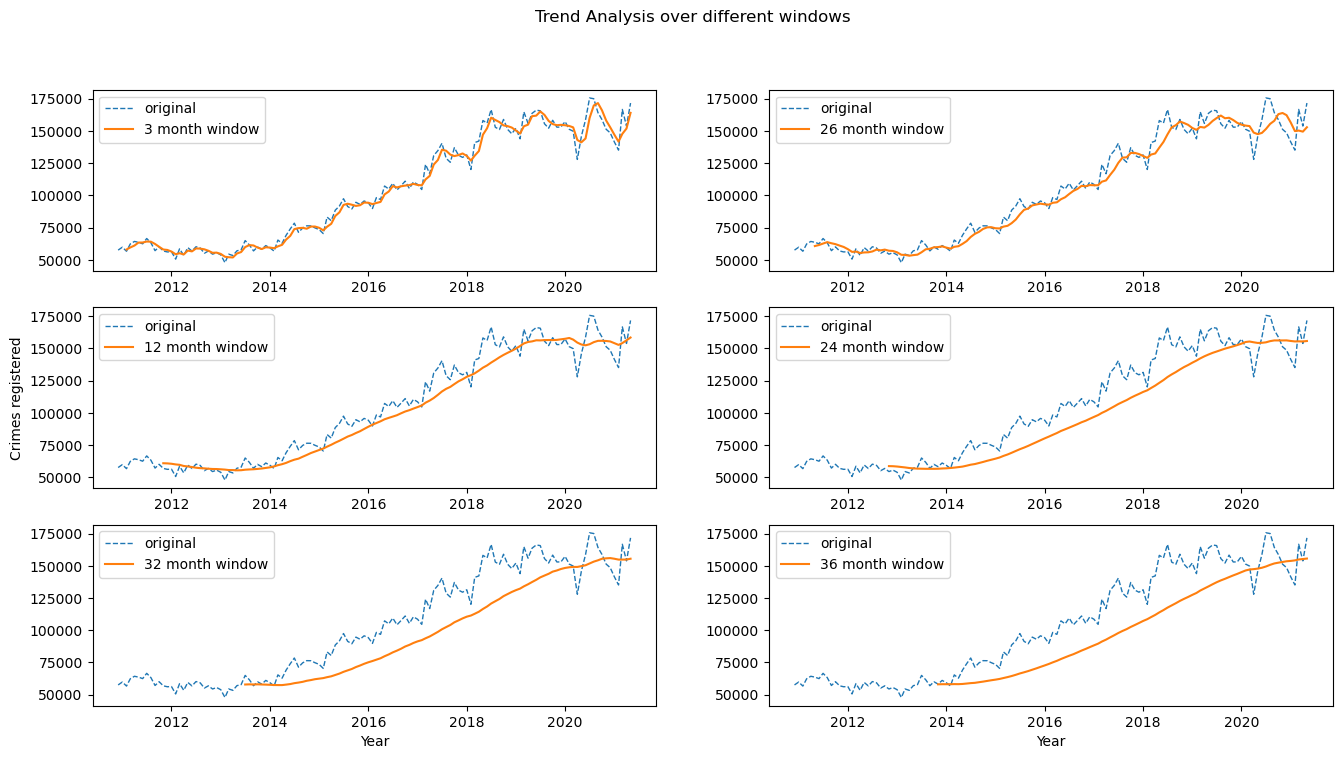

In [ ]:
#Trend analysis over a 3,6, 12 and 24 month window

plt.figure(figsize=(16,8))

plt.subplot(3, 2, 1)
plt.plot(v_crime, label = 'original', linewidth = 1, linestyle='--')
plt.plot(v_crime.rolling(3).mean(), label = '3 month window')
plt.legend(loc='best')

plt.subplot(3, 2, 2)
plt.plot(v_crime, label = 'original', linewidth = 1, linestyle='--')
plt.plot(v_crime.rolling(6).mean(), label = '26 month window')
plt.legend(loc='best')

plt.subplot(3, 2, 3)
plt.plot(v_crime, label = 'original', linewidth = 1, linestyle='--')
plt.plot(v_crime.rolling(12).mean(), label = '12 month window')
plt.legend(loc='best')
plt.ylabel('Crimes registered')

plt.subplot(3, 2, 4)
plt.plot(v_crime, label = 'original', linewidth = 1, linestyle='--')
plt.plot(v_crime.rolling(24).mean(), label = '24 month window')
plt.legend(loc='best')

plt.subplot(3, 2, 5)
plt.plot(v_crime, label = 'original', linewidth = 1, linestyle='--')
plt.plot(v_crime.rolling(32).mean(), label = '32 month window')
plt.legend(loc='best')
plt.xlabel('Year')

plt.subplot(3, 2, 6)
plt.plot(v_crime, label = 'original', linewidth = 1, linestyle='--')
plt.plot(v_crime.rolling(36).mean(), label = '36 month window')
plt.legend(loc='best')

plt.xlabel('Year')
plt.suptitle('Trend Analysis over different windows')
plt.show()

Choosing the window size is crucial to calculate the moving average. As mentioned earlier the smaller window sizes (less than 12) show more variations compared to the larger ones. This implies that they are responsive to short-term changes. Since the collected time series data is in intervals of months window size 12 would be a safe choice to analyze the trend. We observe that there is a general upward trend starting from the end of 2013 and is on a constant raise till 2019, after which it flattens.

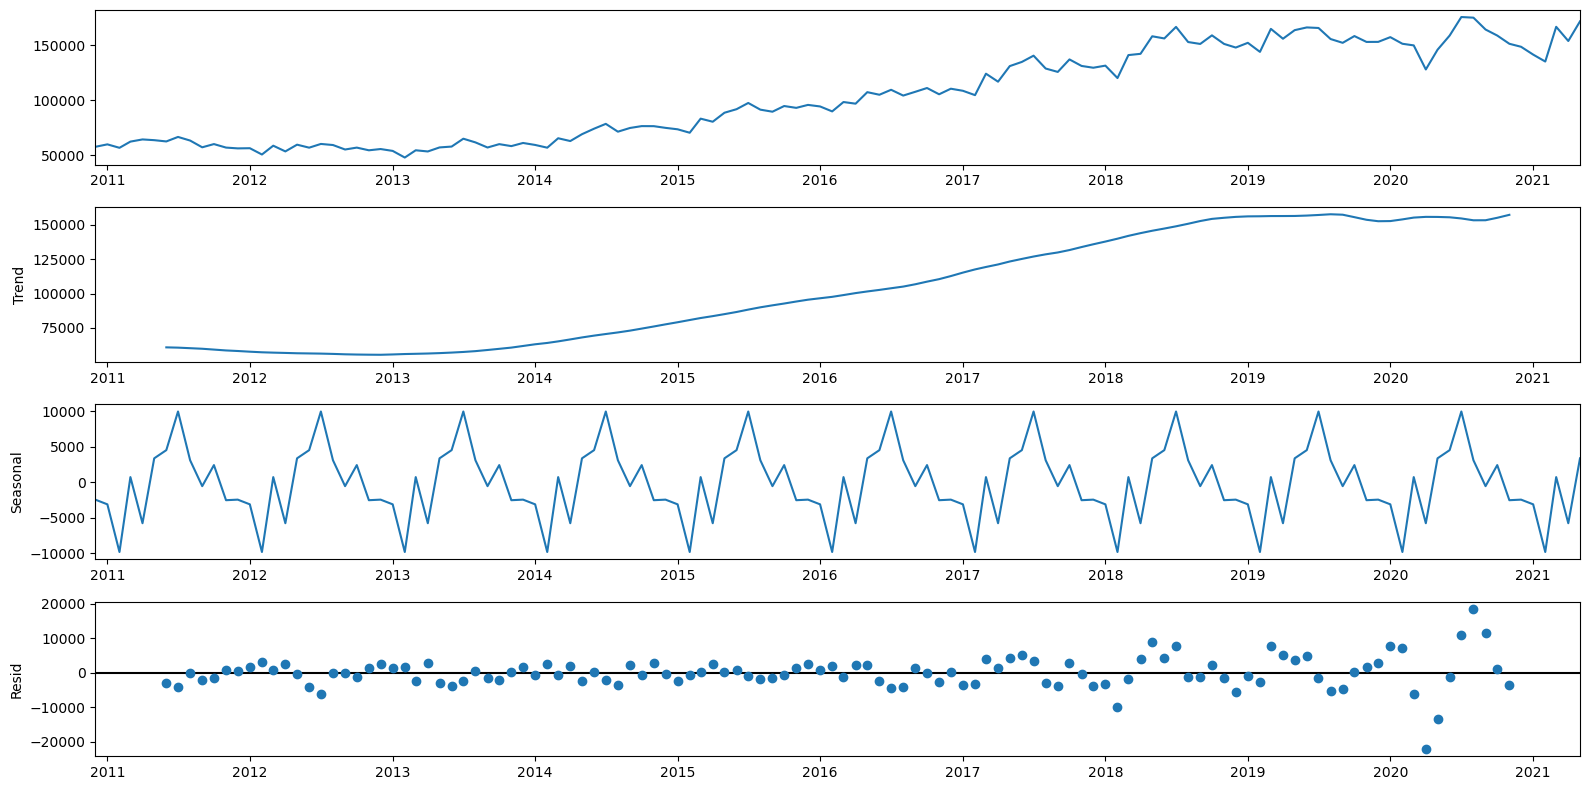

In [ ]:
# Multiplicative decomposition
decompose = seasonal_decompose(v_crime, model = 'additive')
decompose_plot = decompose.plot()
decompose_plot.set_size_inches((16,8))
decompose_plot.tight_layout()

plt.show()

Decomposing time series is a widely used technique to gain a more comprehensive view. Time series data often contains a lot of noise, which makes it difficult to identify trends and patterns. Time series is composed of three components namely trend, seasonal and noise/residual and is generally represented as :

`Time Series = trend + seasonal + noise`  or `Time Series = trend x seasonal x noise`

The first one is called the additive model which is used when the seasonal variation is relatively constant over time and the latter is known as the multiplicative model which is used when the seasonality increases over time.

In our time series data, when the seasonal variation is relatively constant over time, hence the series is additive. Using the function `seasonal_decompose(data, model = 'additive')` from the package `statsmodels.tsa.seasonal` the time series can be broken down into its respective components for easier analysis.


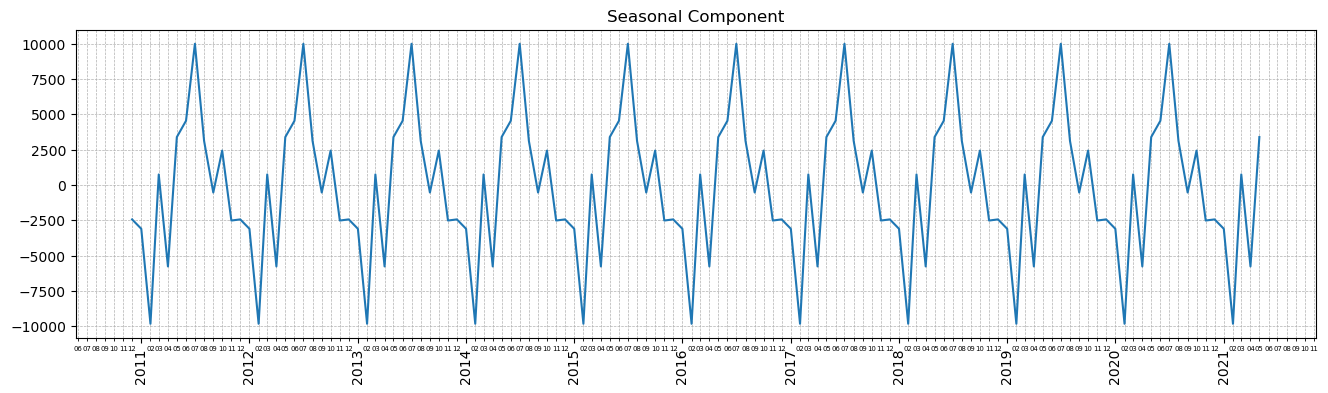

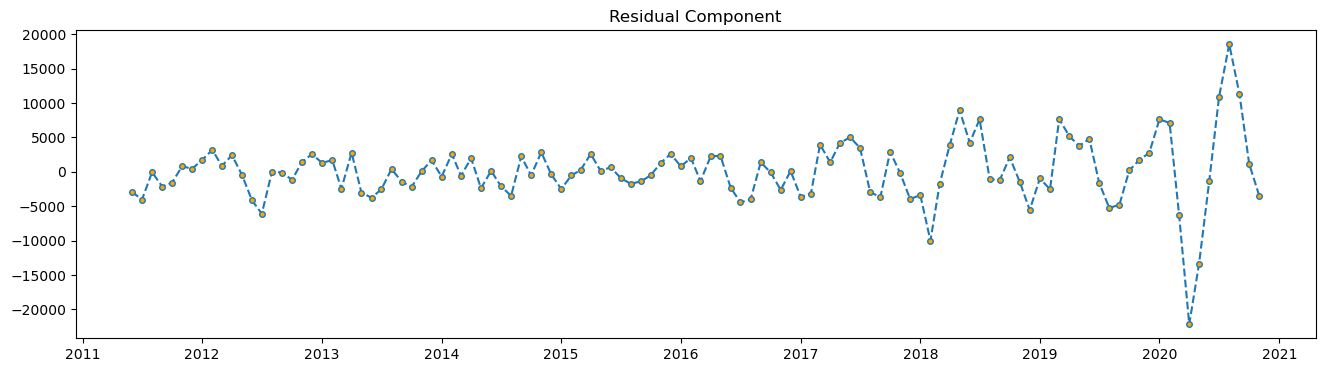

In [ ]:
# A detailed perspective of the time series component

# Seasonal component
fig, ax = plt.subplots(1,1, figsize=(16, 4))

plt.plot(decompose.seasonal)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

ax.tick_params(axis='x', which = 'major', labelrotation=90, labelsize = 10)
ax.tick_params(axis='x', which = 'minor', labelsize = 5)

ax.xaxis.grid(True,'minor',linewidth=0.5, linestyle = '--')
ax.xaxis.grid(True,'major',linewidth=0.5, linestyle = '--')
ax.yaxis.grid(True,'major',linewidth=0.5, linestyle = '--')
plt.title('Seasonal Component')
plt.show()

# Residual plot
plt.figure(figsize=(16,4))
plt.plot(decompose.resid, linestyle='--', marker = 'o', mfc = 'orange', markersize = 4)
plt.title('Residual Component')
plt.show()

Key takeaways from the seasonal component:
- There is a yearly recurring pattern.
- Maximum number of crimes seems to be committed/reported during July,
- Least number of crimes are being committed/reported during February.
- The number of crimes seems to decrease at the start of the year but steeply increases between February - March and then dips again in the month of April.
- The residual component shows high variability towards the end of the series. This could be due to the implementation of lockdown. These patterns can be better explained or interpreted by correlating the number of crimes to other variables / factors, but our problem statement does not require such analysis. Moving forward with the time series analysis.


# Predicting the level of violent crimes in April 2020

### Need for splitting the data before further analysis

Time series analysis is essentially a method used to forecast or predict values based on historical data. This implies that in a realistic scenario, statistical test and model building is done on observed data.

Similarly, we are splitting the data before further analysis to create a realistic scenario where the model is evaluated on unseen data. Hence including data post lockdown (after March 2020) will lead to data leakage. Introducing information from the future can affect the model’s performance (over optimistic response).
Here we are considering the pre-lockdown (before April 2020) as the  training set and post-lockdown the test set.

Observing the residual component from the `seasonal_decompose` plot, we can see that there are outliers present. The presence of null values and outliers can affect the model performance and lead to incorrect results. Normalizing the trainset will mitigate this issue.

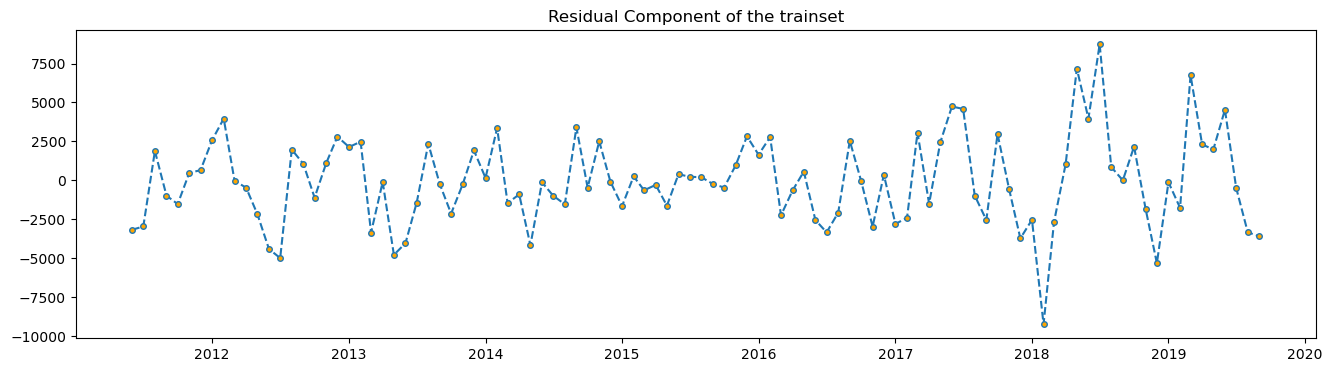

In [ ]:
train_decomp = seasonal_decompose(x = pre_locdown, model="additive", period=12)
plt.figure(figsize=(16,4))
plt.plot(train_decomp.resid, linestyle='--', marker = 'o', mfc = 'orange', markersize = 4)
plt.title('Residual Component of the trainset')
plt.show()

In [ ]:
#normalizing the trainset
train = ((pre_locdown - pre_locdown.rolling(12).mean())/pre_locdown.rolling(12).std()).dropna()

### Stationarity check

If the time series is nonstationary meaning the statistical properties keep changing which can result in an unreliable prediction. If the time series shows constant variance, then the time series analysis model can detect trends and provide accurate results.

The stationarity test can be done graphically by calculating and plotting the rolling statistics of the series. If the series were to be stationary the plot line would be constant over time.

In certain cases, graphs can be hard to interpret so to be sure we can resort to performing the Augmented Dicky Fuller (ADF) test, which is a statistical hypothesis testing method to find out if the series is stationary. The ADF test will provide us with the test statistics, p value and critical values at confidence levels 1%, 5% and 10%.

The null hypothesis of the test is that unit root exists i.e. the series is nonstationary and the alternate being series is stationary. The conditions for the null hypothesis to be rejected are :
1. test statistics less than critical values and
2. p value less than significant level (0.05)


In [ ]:
# defining a function for performing Augmented Dickey Fuller test and Rolling Statistics
def stationarity_test(data):
    dftest = adfuller(data, autolag='AIC')
    print("ADF test stats :",dftest[0])
    print("p-value        :",dftest[1])
    print("No. of lags    :",dftest[2])
    print("Critical Values:")
    for key, val in dftest[4].items():
        print("\t ", key, "  :", val)

    rolling_mean = data.rolling(12).mean()
    rolling_std = data.rolling(12).std()

    plt.figure(figsize=(16,6))

    plt.plot(data, color = 'black', label = 'original')
    plt.plot(rolling_mean, color = 'blue', label = 'Rolling mean')
    plt.plot(rolling_std, color = 'green', label = 'Rolling Std')
    plt.legend(loc='best')

    plt.title("Rolling Statistics")
    plt.show()

# ADF test should give p < 0.05 and Test stats < Critical values

ADF test stats : -1.0509409706930701
p-value        : 0.7342346094257223
No. of lags    : 12
Critical Values:
	  1%   : -3.506944401824286
	  5%   : -2.894989819214876
	  10%   : -2.584614550619835


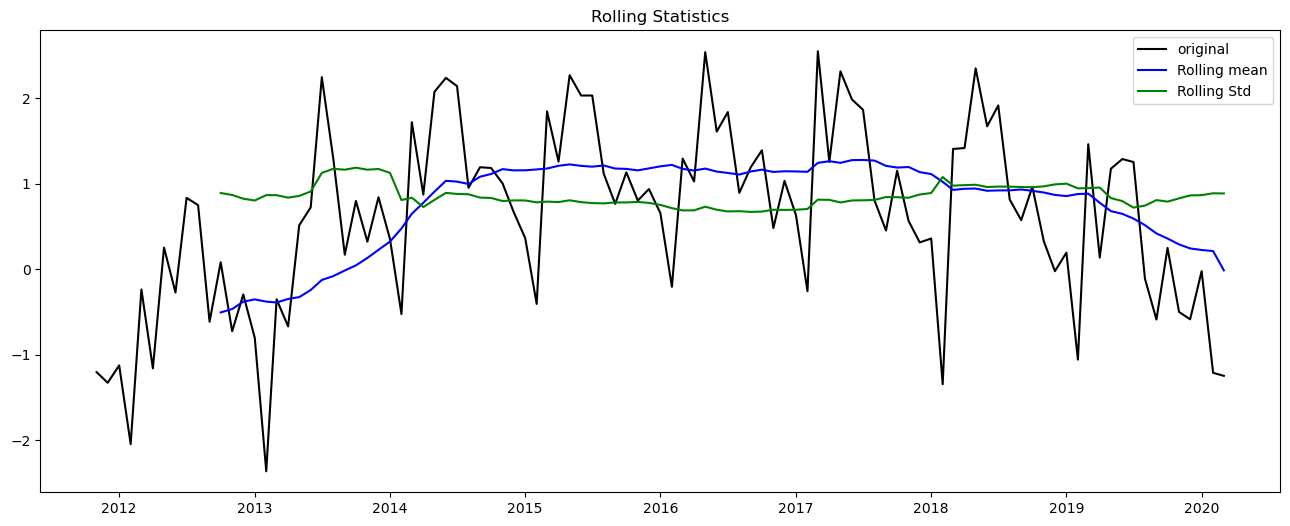

In [ ]:
# original data
stationarity_test(train)

We observe that the time series data is nonstationary as it does not have a constant mean and standard deviation. And the null hypothesis is rejected from ADF test results.
There are multiple methods used to transform the series from non-stationary to stationary.
- Detrending the data (removing the trend component from the time series)
- Log transforming the series
- Square root transformation
- Cube root transformation
- Differencing the time series using the `diff()`function in pandas.
- This can also be done by shifting the series using `shift()` and taking the difference between the original series and the shifted series.


ADF test stats : -1.5753630009409763
p-value        : 0.4959565492109624
No. of lags    : 2
Critical Values:
	  1%   : -3.5087828609430614
	  5%   : -2.895783561573195
	  10%   : -2.5850381719848565


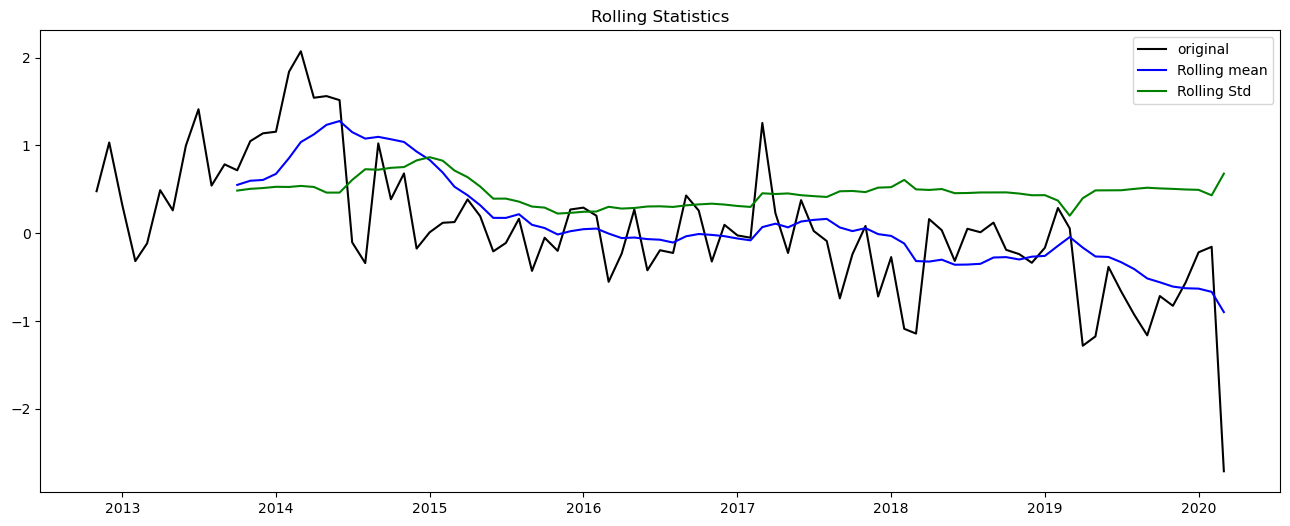

In [ ]:
# Shifting the series
diff1 = train.diff(12).dropna()
stationarity_test(diff1)

Performing both graphical and statistical stationarity test on the transformed data, we observe that first order is not stationary.

ADF test stats : -3.089445569484655
p-value        : 0.027344187555364254
No. of lags    : 12
Critical Values:
	  1%   : -3.53692771987915
	  5%   : -2.907887369384766
	  10%   : -2.591493291015625


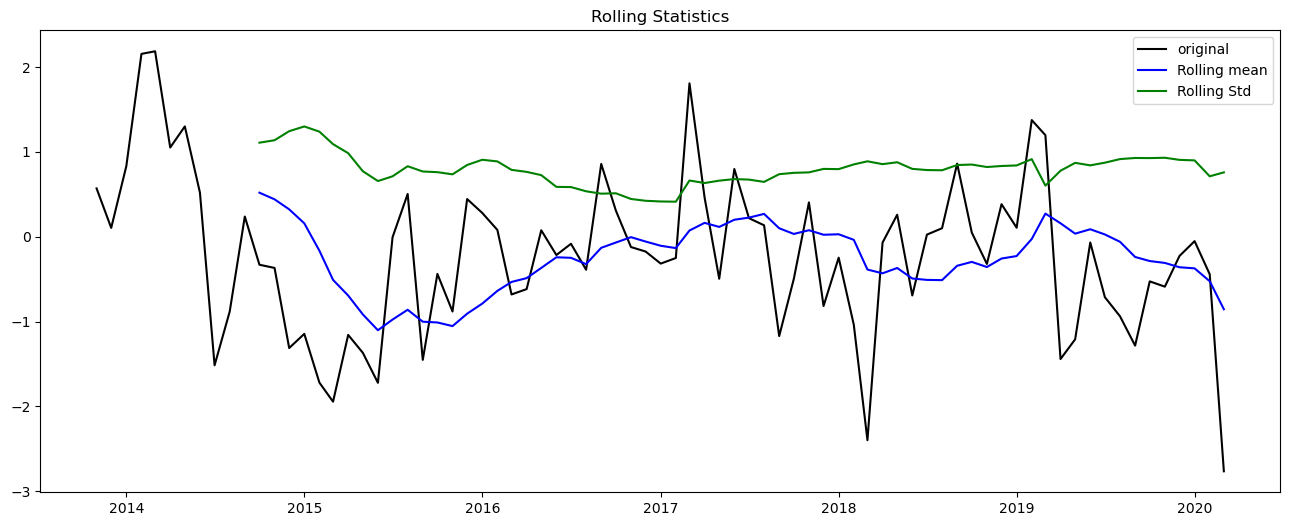

In [ ]:
# Shifting the series (2nd Order differencing)
diff2 = diff1.diff(12).dropna()
stationarity_test(diff2)

The rolling statistics graph plotted after removing the trend component from the data reveals that the mean and standard deviation is linear and constant over time. But the conditions for rejecting the null hypothesis are not completely met. The calculated p value is indeed less than the significant value, however the ADF test statistic is not less than all the critical values. So, we conclude that second order differnced data is not stationary.

ADF test stats : -0.558601181551208
p-value        : 0.8800648037058983
No. of lags    : 12
Critical Values:
	  1%   : -3.518281134660583
	  5%   : -2.899878185191432
	  10%   : -2.5872229937594873


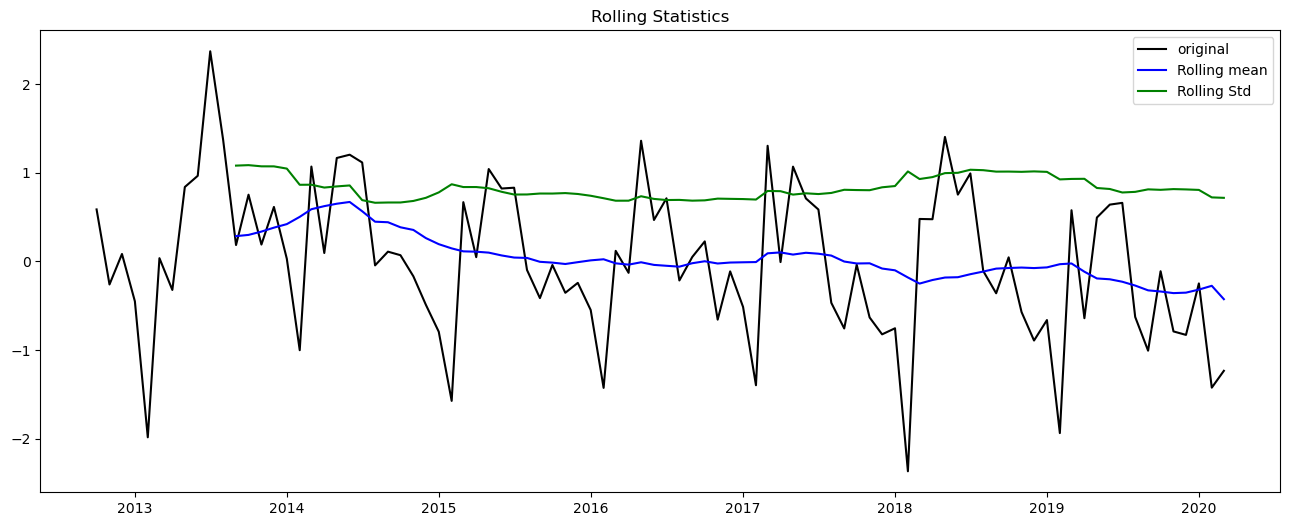

In [ ]:
detrend = (train - train.rolling(12).mean()).dropna()
stationarity_test(detrend)

ADF test stats : -4.908274089627003
p-value        : 3.360388535641882e-05
No. of lags    : 0
Critical Values:
	  1%   : -3.518281134660583
	  5%   : -2.899878185191432
	  10%   : -2.5872229937594873


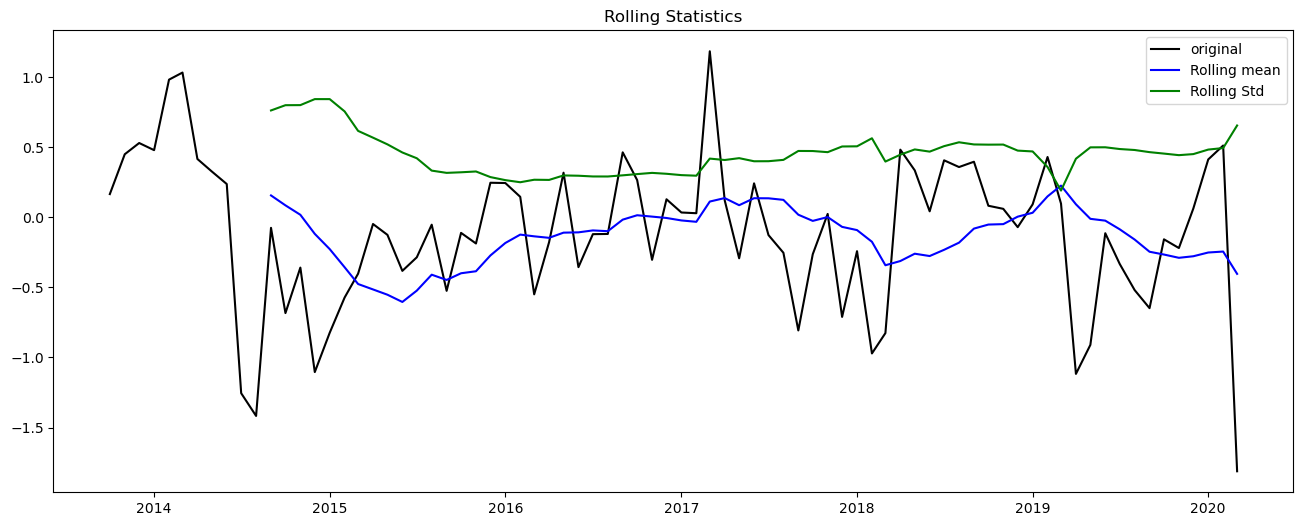

In [ ]:
# First order differencing the detrended data
diff1_det = detrend.diff(12).dropna()
stationarity_test(diff1_det)

Performing a stationary test on the first differenced detrended data we find that both the conditions for rejecting the null hypothesis are met. The p value is way lesser than the significant value (0.05) and the test statistic is less than all the critical values.

### Model selection

ARIMA is a widely used model for time series forecasting. ARIMA stands for Autoregressive Integrated Moving Average where AR, I and MA all contribute to forecasting values.

The Autoregression model (AR) helps forecast value using a linear combination of the past values i.e. we use lagged values of the target as input to predict the future. The Moving average (MA) model uses past forecast residuals to predict future values (Cesario, Catlett and Talia, 2016). The number of differencing applied to make the time series data stationary is represented by Integrated (I).

Parameters of an ARIMA model is represented as (p,d,q) where :
- p –> AR model
- d –> Integrated
- q –> MA model


From the stationarity test we observe that the stationary data is not strictly stationary, the seasonal component still remains. ARIMA cannot be used in this as it fails to consider the seasonal component in its analysis.

This can also be validated by observing the autocorrelation plot below. The ACF plot reveals that there is a significant peak at 12 revealing seasonality. So ARIMA might not be the best model.

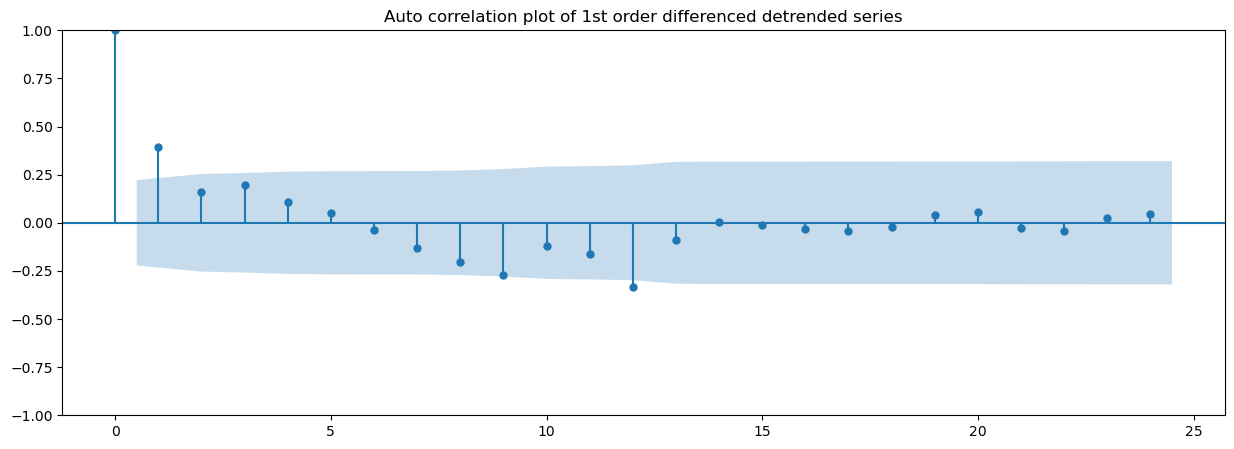

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(diff1_det, lags = 24, title='Crime count', ax=ax)
plt.title("Auto correlation plot of 1st order differenced detrended series")
plt.show()


Using Seasonal ARIMA (SARIMA) instead, we’ll be able to account for the seasonal component of the data (Noor et al., 2022). The parameters calculated are same as in ARIMA, additionally a seasonal component is added to the model.

These are denoted by :
- P – Seasonal AR model
- D – Seasonal Integrated
- Q – Seasonal MA model
- m – Number of observations in a year
and is represented as (p,d,q) (P,D,Q)m.


To find out the order of the autoregressive and moving average model, plotting, and observing the lags on a PACF and ACF plot can be useful. PACF is used for tuning the AR model while ACF is for MA model. We observe that there is a significant peak in the 1st lag in both plots.

We perform a grid search to find the best possible combination of (p,d,q) (P,D,Q)m and compare their Akaike Information Criteria (AIC values). The combination with the lest AIC value can be chosen for model building as AIC essentially measures the goodness of fit.


c:\Users\vishw\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


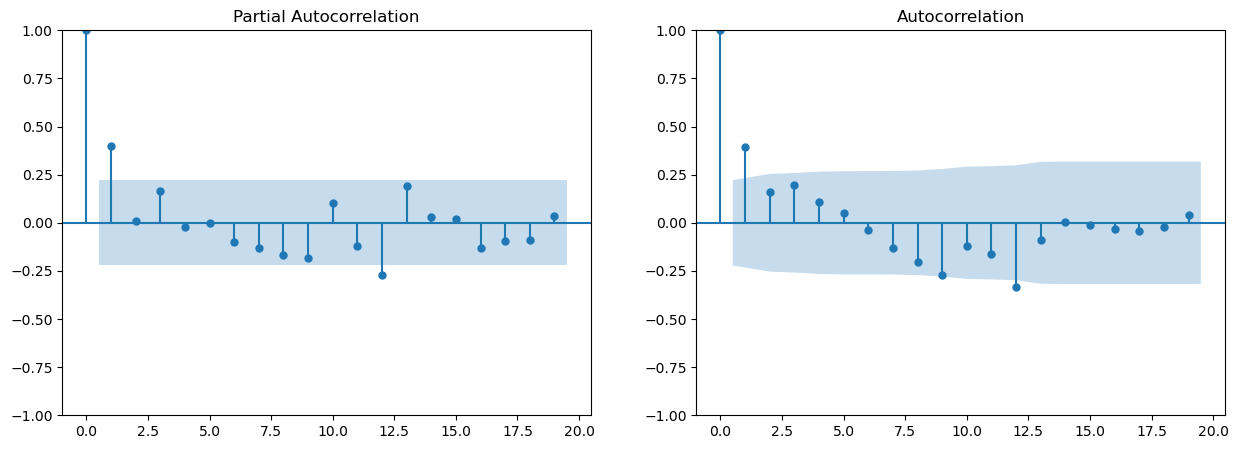

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot_pacf(diff1_det, ax = ax[0]);
plot_acf(diff1_det, ax = ax[1]);

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
p = q = range(0,2)
d = 1 # the value of d is set to one as it took 1 differncing to convert the detrended data to stationary
seasonal_period = 12
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, [d], q))]

In [ ]:
#detrend
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(diff1_det,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'\
.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:170.15254676329533
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:144.2793407678904
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:145.3122829625
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:142.1587977739522
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:160.04372074228675
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:136.88951900393795
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:135.2961450836669
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:133.0069638940813
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:168.0967368738033
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:143.11710670086686
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:141.00094620075924
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:139.3327864640751
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:158.5827243369348
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:134.94243246615048
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:134.47459393794267
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:131.90905075898075


Observing the autocorrelation and partial auto correlation plot, we find that the lags abruptly change after the first lag.
We can assume that the values of p and q to be 1 in this case so the SARIMA model can be represented as (1,1,1) (1,1,1)12.

However, by performing a grid search we find that  
`ARIMA(1, 1, 1)x(1, 1, 1, 12)12` -  *AIC:131.90905075898075* which is the least

                                     SARIMAX Results                                      
Dep. Variable:                              count   No. Observations:                   78
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -60.955
Date:                            Thu, 18 Jan 2024   AIC                            131.909
Time:                                    08:24:28   BIC                            142.781
Sample:                                10-01-2013   HQIC                           136.199
                                     - 03-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4443      0.163      2.731      0.006       0.125       0.763
ma.L1         -0.9981      5.086   

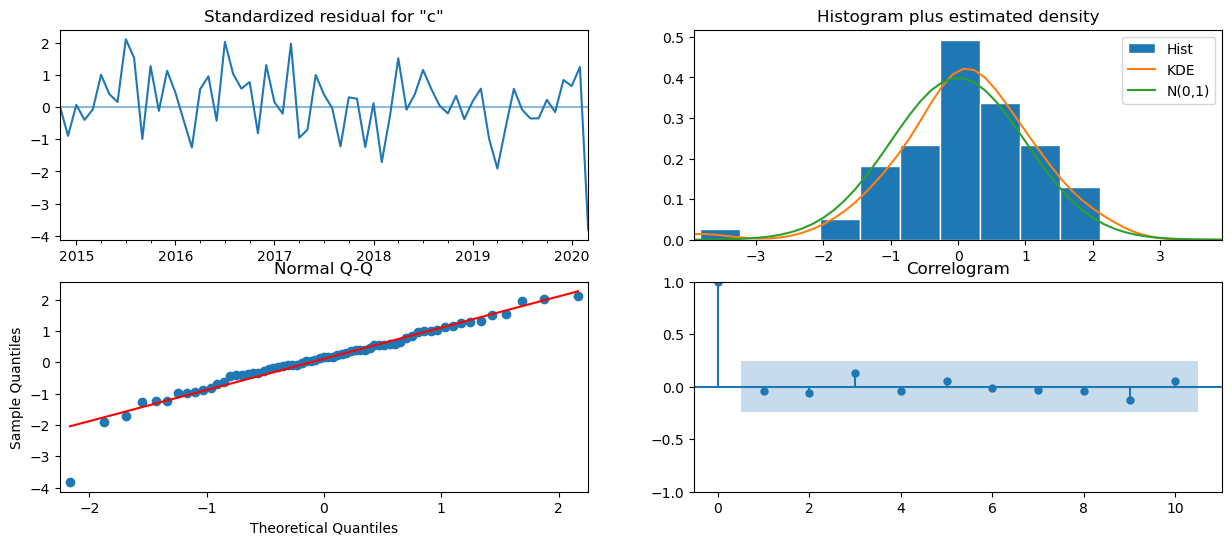

In [ ]:
a_order = (1,1,1)
s_order = (1,1,1,12)

model = SARIMAX(diff1_det, order = a_order, seasonal_order = s_order)
test_results = model.fit()
#Model evaluation
print(test_results.summary())
test_results.plot_diagnostics(figsize=(15,6));

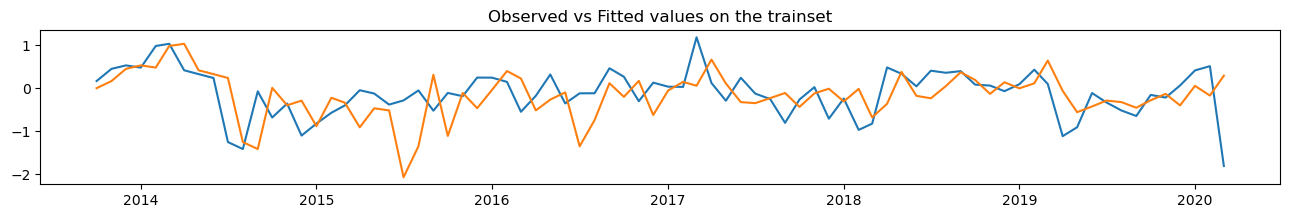

In [ ]:
plt.figure(figsize=(16,2))
plt.plot(diff1_det["count"])
plt.plot(test_results.fittedvalues)
plt.title("Observed vs Fitted values on the trainset")
plt.show()

From the observed values vs fitted values graph we see that the model can capture most of the fluctuations.

# Comparing predicted crime levels with the observed levels

In [ ]:
forecast = test_results.get_forecast(steps=12) #steps = 1 since we are forecasting only for April
confidence_intervals = forecast.conf_int()
#print(confidence_intervals)

In [ ]:
observed = ((v_crime - v_crime.rolling(12).mean())/v_crime.rolling(12).std()).dropna()
observed = observed.diff(12)
#v_crime.index

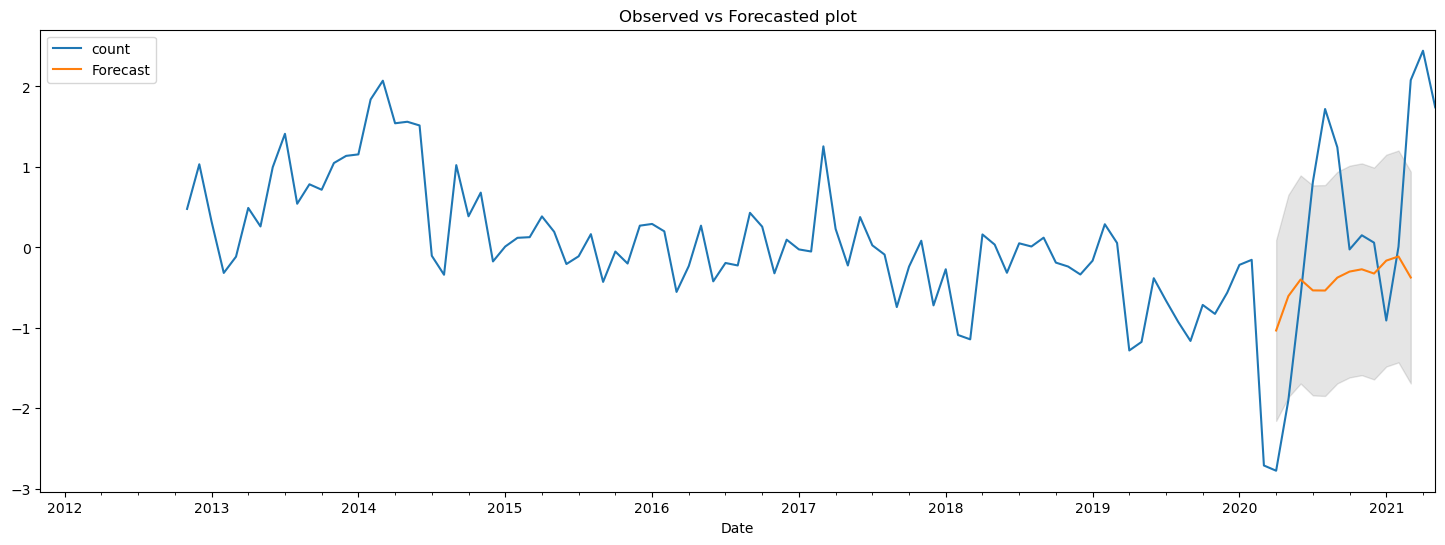

In [ ]:
ax = observed.plot(label='observed', figsize=(18, 6))
#     print(forecast.predicted_mean)
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(confidence_intervals.index,
                confidence_intervals.iloc[:, 0],
                confidence_intervals.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')

plt.title("Observed vs Forecasted plot")
plt.legend()
plt.show()

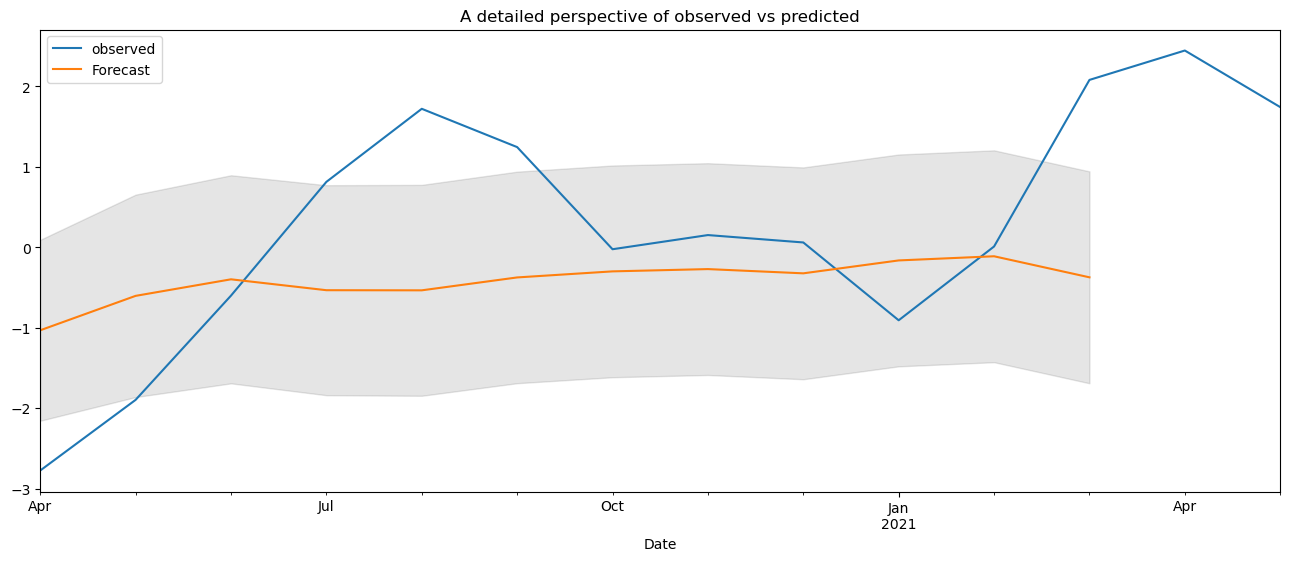

In [ ]:
ax = observed[observed.index > "2020-03-01"]['count'].plot(label='observed', figsize=(16, 6))

forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(confidence_intervals.index,
                confidence_intervals.iloc[:, 0],
                confidence_intervals.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')

plt.title("A detailed perspective of observed vs predicted")
plt.legend()
plt.show()

According to our model, we should be observing a steep increase in the number of crimes committed in the month of April 2020. But we observe a significant decrease in number of crimes committed from the forecasted value for April 2020. It is significant as it's below the expected confidence interval.

# Analyzing the Leicester region

In [ ]:
%%time
# Leicester
#df2 = df.filter(year(df['Month']) >= "2020")
df2 = df.filter((df['LSOA name'].like('Leicester%')) & (df["Crime type"].isin(violent))).select("Month", "Crime type")
ldf = df2.groupBy('Month').count()

CPU times: total: 15.6 ms
Wall time: 43.9 ms


In [ ]:
%%time
#converting spark df to pandas
lpdf = ldf.toPandas()

lpdf.set_index('Month', inplace=True)
lpdf.sort_index(inplace=True)

lpdf.index = pd.to_datetime(lpdf.index)

CPU times: total: 125 ms
Wall time: 2min 11s


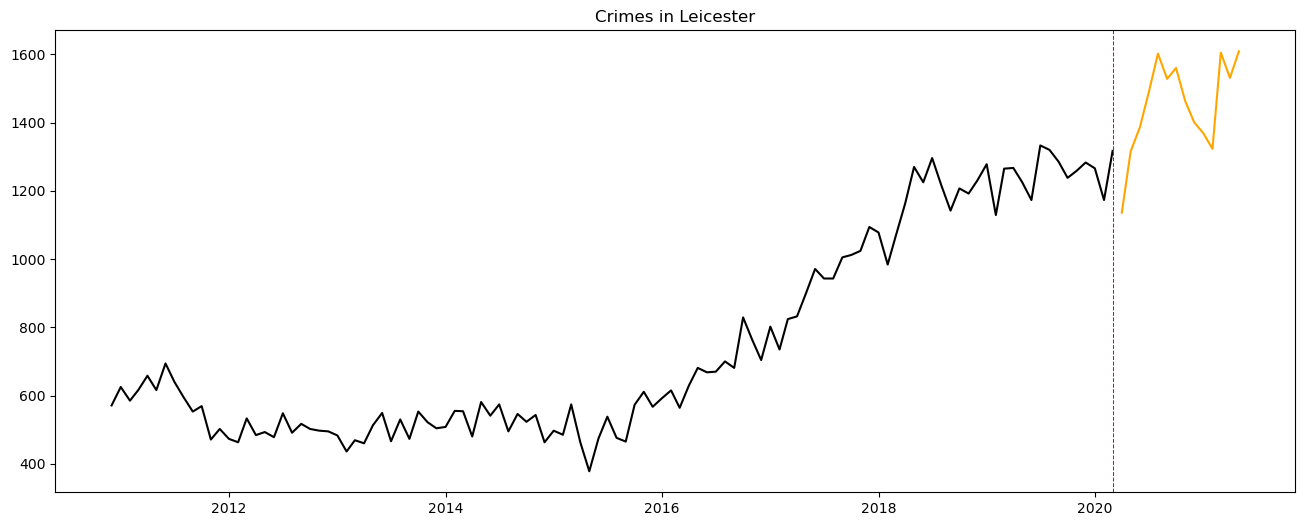

In [ ]:
L_pre_lockdown = lpdf[lpdf.index <= "2020-03-01"]
L_post_lockdown = lpdf[lpdf.index > "2020-03-01"]

plt.figure(figsize=(16,6))
plt.plot(L_pre_lockdown, 'black', linewidth=1.5)
plt.plot(L_post_lockdown, 'orange',linewidth=1.5)

# plotting a vertical line when the lockdown was imposed
lockdown = pd.to_datetime('2020-03-01')
plt.axvline(lockdown, linestyle='--', color = 'red', linewidth = 0.75)

plt.title("Crimes in Leicester")
plt.show()

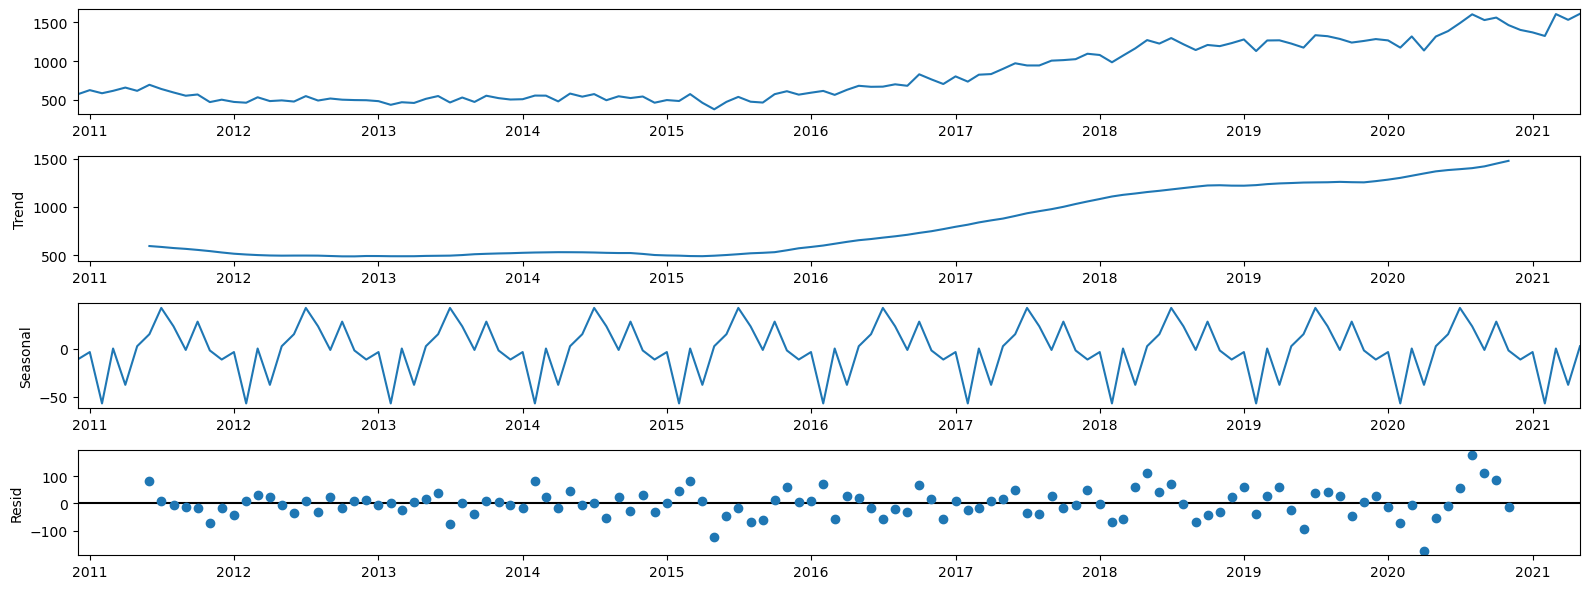

In [ ]:
L_decomp = seasonal_decompose(x = lpdf, model="additive", period=12)
L_decomp = L_decomp.plot()
L_decomp.set_size_inches((16,6))
L_decomp.tight_layout()
plt.show()

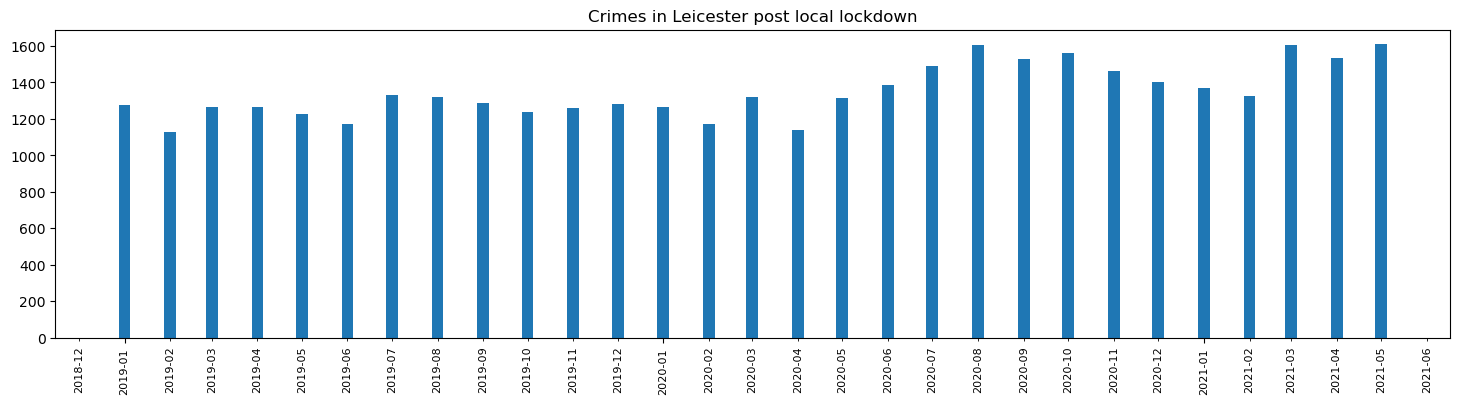

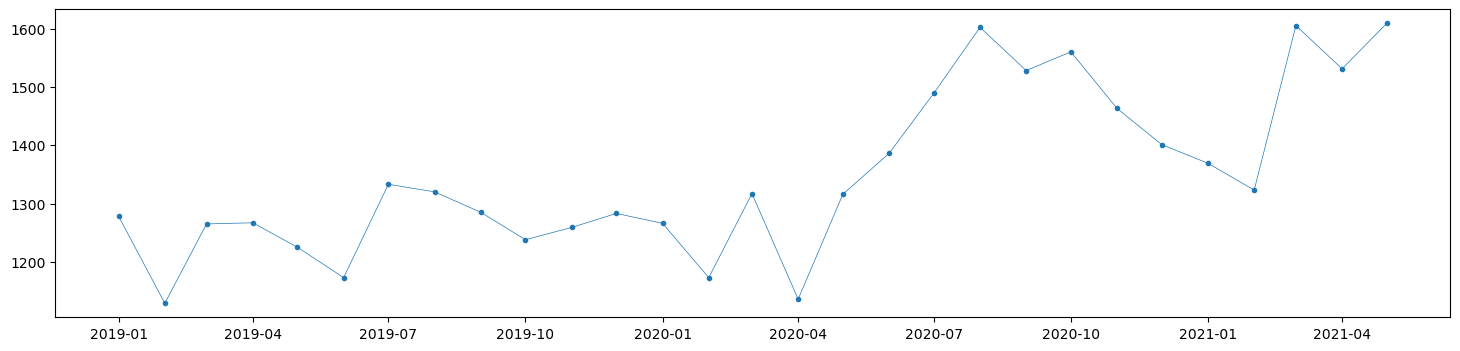

In [ ]:
to_analyze = lpdf[lpdf.index >= '2019-01-01']

#plt.figure(figsize=(16,6))

fig, ax = plt.subplots(figsize=(18, 4))
plt.bar(to_analyze.index, to_analyze['count'], width = 8)

ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m'))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', which = 'both', labelrotation=90, labelsize = 8)

plt.title("Crimes in Leicester post local lockdown")
plt.show()

plt.figure(figsize=(18,4))
plt.plot(to_analyze, marker='.', linestyle='-', linewidth=0.5)
plt.show()

From the overall analysis of the Leicester region, we see that crimes committed is relatively constant till 2016 and increased after. Observing the histogram past **2019-01-01**, we infer that the number of crimes rather increased after the local lockdown was imposed i.e. after **2020-07-01**. Peak number of crimes were committed in the month of august 2020 which was gradually decreased from September 2020.


# Conclusion

With the help of  Pyspark we were able to efficiently read and filter out large amounts of data, combining it with visualizing techniques used in pandas we gained valuable insights. The analysis conducted on the data collected clearly shows that there is an overall increase in violent crimes. This was not always the case; the upward trend seems to be halted and the crimes committed remained static after 2019 with.

Using the SARIMA model, we were able to forecast the number of crimes committed for April and found that there is in fact a decrease in crimes committed post lockdown. Also, these numbers were lower than the confidence intervals of April but exceeded the intervals in July. It is also important to note that only in the Leicester region did the number of crimes increase post lockdown.

In conclusion, the overall crimes decreased after lockdown was imposed but increased steeply after.


Reference :

Cesario, E., Catlett, C. and Talia, D. (2016). Forecasting Crimes Using Autoregressive Models. 2016 IEEE 14th Intl Conf on Dependable, Autonomic and Secure Computing, 14th Intl Conf on Pervasive Intelligence and Computing, 2nd Intl Conf on Big Data Intelligence and Computing and Cyber Science and Technology Congress(DASC/PiCom/DataCom/CyberSciTech). doi:https://doi.org/10.1109/dasc-picom-datacom-cyberscitec.2016.138.

Ferencz, K., Domokos, J. and Levente Kovács (2022). A statistical approach to time series sensor data evaluation using Apache Spark modules. doi:https://doi.org/10.1109/saci55618.2022.9919485.

Kirchmaier, T. and Villa-Llera, C. (2020). COVID-19 and Changing Crime Trends in England and Wales. [online] papers.ssrn.com. Available at: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3700329.

Murdoch, A. and Byczynski, C. (2021). The Impact of the Coronavirus (Sars-Cov-2) Lockdown on Crime in New York and London, March-June 2020: A Comparative Study. International Journal of Business and Management Research, 9(2), pp.124–155. doi:https://doi.org/10.37391/ijbmr.090204.

Noor, T.H., Almars, A.M., Alwateer, M., Almaliki, M., Gad, I. and Atlam, E.-S. (2022). SARIMA: A Seasonal Autoregressive Integrated Moving Average Model for Crime Analysis in Saudi Arabia. Electronics, [online] 11(23), p.3986. doi:https://doi.org/10.3390/electronics11233986.
